# Import Packages

In [31]:
import cv2
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Camera Calibration and Distortion Correction

In [32]:
# https://opencv24-python-tutorials.readthedocs.io/en/stable/py_tutorials/py_calib3d/py_calibration/py_calibration.html
# This function is used to obtain the camera matrix, distortion coefficients, rotation and translation vectors.
# These will be used to correct the error in photos resulting from the camera lens.
# eg: straight lines appear curvy, specially away from the origin.
def calibrate():

    # We need to get 3D object points representing real coordinates and their corresponding 2D points representing
    # the camera coordinates.
    # We will use chessboard images for this sake as in reality, the corners are equally distant so we can get the
    # real coordinates easily by creating array [0. 0. 0.], [1. 0. 0.], [2. 0. 0.].....[8, 5, 0].
    # Note: the z-axis values are assumed to be 0.
    objp = np.zeros((9 * 6, 3), np.float32)

    # np.mgrid function help in creating a numpy array of grid coordinates as stated above
    # The last column is left = 0 "for the z-axis"
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)


    # List for all object points & img points from all images
    objpoints = []
    imgpoints = []

    # Directory for all chessboard images used in calibration
    images = glob.glob('camera_cal/calibration2.jpg')
    for img in images:
        image = cv2.imread(img)                                            # Read the images
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)               # Convert to GRAY for the findChessboardCorners fn
        # Get 9x6 corners coordinates of chessboard. return_val = TRUE if corners are found
        return_val, corners = cv2.findChessboardCorners(gray_image, (9, 6), None)

        # If the corners are found, append the objp to object points and the corresponding corners to imgpoints
        if return_val == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Uncomment these lines to see the detected corners
            #img = cv2.drawChessboardCorners(image, (9, 6), corners, return_val)
            #cv2.imshow('img', img)
            #cv2.waitKey(50000)

    # Get the image size: (horizontal, vertical)
    image_size =(image.shape[1], image.shape[0])

    # Get the camera matrix, distortion coefficients, rotation and translation vectors
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    param = {}
    param['mtx'] = mtx
    param['dist'] = dist
    pickle.dump(param, open('calibration_param.pickle', 'wb'))


# Use the camera matrix, distortion coefficients to undistort the image
def undistort_image(image):
    # Read saved parameters
    with open('calibration_param.pickle', mode='rb') as f:
        param = pickle.load(f)
    mtx = param['mtx']
    dist = param['dist']
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted_image



# Test and run the function
# calibrate()
# image = cv2.imread('straight_lines1.jpg')
# undistorted_image = undistort_image(image)
# undistorted_image_RGB = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB)
# plt.imshow(undistorted_image_RGB)
# plt.show()



# Perspective Transform

In [33]:
#we will find the image form a bird eye view perspective
def perspective_transform(binary_img):  #this function takes a binary image
    srcpoints = np.float32([(550, 460),(150, 720),(1200, 720),(770, 460)])  #we specify any four points in the image as a source points
    dstpoints = np.float32([(100, 0),(100, 720),(1100, 720),(1100, 0)])     #we also specify  a four points of a rectangle as a distinatiton points

    img_size = (binary_img.shape[1], binary_img.shape[0]) #we specify the binary image size

    M = cv2.getPerspectiveTransform(srcpoints, dstpoints) #matrix

    warped_image = cv2.warpPerspective(binary_img, M, img_size, flags=cv2.INTER_LINEAR) #make the perspective

    return warped_image

# we will return back to the driver view 
def inv_perspective_transform(binary_img):  #we'll give it also a binary image
    dstpoints = np.float32([(550, 460),(150, 720),(1200, 720),(770, 460)])   #we specifiy the four points in the image we specified before in the source as destination
    srcpoints = np.float32([(100, 0),(100, 720),(1100, 720),(1100, 0)])      #and we also specify the rectangle points as a source points

    img_size = (binary_img.shape[1], binary_img.shape[0])   #we specify the binary image sizes

    Minv = cv2.getPerspectiveTransform(srcpoints, dstpoints)  #inverse matrix

    warped_image = cv2.warpPerspective(binary_img, Minv, img_size, flags=cv2.INTER_LINEAR) #make the inverse perspective

    return warped_image


# Color Thresholding

In [34]:
def threshold_rel(img, lo, hi):  
    vmin = np.min(img)  # get minimum pixels in an image
    vmax = np.max(img)  # get max pixels in the image
    
    # interpolation on vlo, vhi to map (lo->hi) to range of vmin->vmax
    vlo = vmin + (vmax - vmin) * lo  
    vhi = vmin + (vmax - vmin) * hi
    return np.uint8((img >= vlo) & ( img <= vhi)) * 255  


def threshold_abs(img, lo, hi):
    return np.uint8((img >= lo) & (img <= hi)) * 255  # check if the img is within the range


def forward(img):
    """ Take an image and extract all relavant pixels.
    Parameters:
        img (np.array): Input image
    Returns:
        binary (np.array): A binary image represent all positions of relavant pixels.
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # All these channels are for edge detection
    h_channel = hls[:, :, 0]
    l_channel = hls[:, :, 1]  # l_channel is used to adjust lightening to cover different weather conditions 
    s_channel = hls[:, :, 2]
    v_channel = hsv[:, :, 2]

    right_lane = threshold_rel(l_channel, 0.86, 1.0)  # l_channel of white color range
    right_lane[:, :750] = 0  

    left_lane = threshold_abs(h_channel, 20, 30) #hue lower and upper range of yellow or white color depending on the left lane color
    left_lane &= threshold_rel(v_channel, 0.7, 1.0) #eliminate other objects than the straight line in the left lanes
    left_lane[:, 550:] = 0

    img2 = left_lane | right_lane

    return img2

#Test and run the function
# image=cv2.imread("straight_lines1.jpg")
# image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# im2=forward(image)
# plt.imshow(im2)


# Finding the lane pixels using sliding windows

In [35]:
class Lane:
    def __init__(self):

        self.nwindows = 9                                               # Number of sliding windows
        self.window_height = None
        self.margin = 100                                               # The width of the window:margin .centre. margin
        self.minpix = 50            # 200                                # The minimum number of found pixels in the window to recenter it
        self.nonzero = None
        self.nonzerox = None
        self.nonzeroy = None
        self.image = None

    def in_window(self, center, margin, height):                         # Check that a certain point is in the window
        leftx = center[0] - margin
        rightx = center[0] + margin
        upy = center[1] - height // 2
        downy = center[1] + height // 2

        x_inside = (self.nonzerox >= leftx) & (self.nonzerox <= rightx)
        y_inside = (self.nonzeroy >= upy) & (self.nonzeroy <= downy)
        return self.nonzerox[x_inside & y_inside], self.nonzeroy[x_inside & y_inside]

    def initialize_variables(self, image):
        self.image = image
        self.nonzero = image.nonzero()                # Return a tuple of arrays for each dimension including the indices of nonzero elements
        self.nonzerox = np.array(self.nonzero[1])     # Equivalent to self.nonzero[1]
        self.nonzeroy = np.array(self.nonzero[0])
        self.window_height = np.int(image.shape[0] // self.nwindows)

    def histogram(self, image):
        bottom_image = image[image.shape[0] // 2:,:]                    # Extract the bottom half of the image where the lanes lie
        return np.sum(bottom_image, axis = 0)                           # Sum the intensities over the y-axis for each x

    def find_lanes(self, image):
        self.initialize_variables(image)
        h = self.histogram(image)
        midx = h.shape[0] // 2
        left_x = np.argmax(h[: midx])                                    # Get the x of maximum histogram value in the left
        right_x = np.argmax(h[midx: ]) + midx                            # Get the x of maximum histogram value in the right
        y = image.shape[0] + self.window_height // 2                    # Required so that when we enter the for loop the
                                                                        # initial y is image.shape[0] - self.window_height // 2

        leftx, lefty, rightx, righty = [], [], [], []                   # Empty lists for the left and right lane pixels
        for window in range(self.window_height):
            y = y - self.window_height
            left_center = (left_x, y)
            right_center = (right_x, y)
            # print(left_center[0], self.margin)
            left_x_inwindow , left_y_inwindow = self.in_window(left_center, self.margin, self.window_height)
            right_x_inwindow, right_y_inwindow = self.in_window(right_center, self.margin, self.window_height)
            # Extends the list with the found indices in the window
            leftx.extend(left_x_inwindow)
            lefty.extend(left_y_inwindow)
            rightx.extend(right_x_inwindow)
            righty.extend(right_y_inwindow)
            # Recenter the window
            if len(left_x_inwindow) > self.minpix:
                left_x = np.int32(np.mean(left_x_inwindow))
            if len(right_x_inwindow) > self.minpix:
                right_x = np.int32(np.mean(right_x_inwindow))

        return leftx, lefty, rightx, righty

    def search_around_poly(self, image, leftpoly, rightpoly):
        self.initialize_variables(image)
        margin = 100
        # if the lane has no abrupt curves, then we would expect the lane to be close to the previous found lane
        # Substitute by the lane equation using y points and check if the corresponding x points lies within a certain margin
        # If so, then this points are part of the lane and use them to calculate the new lane polynomial
        left_lane_indices = \
            ((self.nonzerox > (leftpoly[0] * (self.nonzeroy**2) + leftpoly[1] * (self.nonzeroy) + leftpoly[2]-margin))
             &(self.nonzerox < (leftpoly[0] * (self.nonzeroy**2) + leftpoly[1] * (self.nonzeroy) + leftpoly[2]+margin))
             ).nonzero()[0]

        right_lane_indices = \
        ((self.nonzerox > (rightpoly[0] * (self.nonzeroy ** 2) + rightpoly[1] * (self.nonzeroy) + rightpoly[2] - margin))
         & (self.nonzerox < (rightpoly[0] * (self.nonzeroy ** 2) + rightpoly[1] * (self.nonzeroy) + rightpoly[2] + margin))
         ).nonzero()[0]

        leftx = self.nonzerox[left_lane_indices]
        lefty = self.nonzeroy[left_lane_indices]
        rightx = self.nonzerox[right_lane_indices]
        righty = self.nonzeroy[right_lane_indices]

        return leftx, lefty, rightx, righty

#Test and run the function
# l = Lane()
# image = cv2.imread('straight_lines1.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# l.find_lanes(image)


# Fitting a second order polynomial to the found lane pixels

In [36]:
#Here we will fit a seconed order polynomial between the pixels of the lane and draw the lane 
def fit_and_draw_lane(leftx, lefty, rightx, righty, left_fit, right_fit, img, first_run):
    # Fit a second order polynomial to each with np.polyfit()
    if len(lefty) > 1500 or first_run:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(righty) > 1500 or first_run:
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    maxy = img.shape[0] - 1  # getting the max height of the image
    miny = img.shape[0] // 3  # taking the min to be the floor of third the height
    if len(lefty):  # getting max and min of left lane height along with the previously assumed max and min above
        maxy = max(maxy, np.max(lefty))
        miny = min(miny, np.min(lefty))

    if len(righty):  # getting max and min of right lane height along with the previously assumed/calc max and min above
        maxy = max(maxy, np.max(righty))
        miny = min(miny, np.min(righty))

    # Generate y values then calculate x values from polynomial function
    ploty = np.linspace(miny, maxy, img.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Visualization
    out_img = np.dstack((img, img, img))  # converting them to 3 channels

    # match a straight line between every 2 points in front of each other in the right and left lanes with green line
    for i, y in enumerate(ploty):
        l = int(left_fitx[i])
        r = int(right_fitx[i])
        y = int(y)
        cv2.line(out_img, (l+16, y), (r-16, y), (0, 255, 0))  # green filling
        cv2.line(out_img, (l-15, y), (l+15, y), (255, 0, 0))  # red left lane
        cv2.line(out_img, (r-15, y), (r+15, y), (0, 0, 255))  # blue right lane

    return left_fit, right_fit, out_img


# Calculating  Car Offset and Radius of Curvature

In [37]:
def measure_center_curvature(left_fit_coef, right_fit_coef, image_shape):
    """
    It takes the polynomial functions and original image dimensions.
    It calculates the offset of the car from the center of the lanes and the curvature in meters.
    It returns the offset and a direction the car to go to and the right and left curvature of the road.
    """

    # Conversions from pixels to meters
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700  # meters per pixel in x dimension

    ############ Calculating the car offset
    # Get the position of the car (in the middle of the image)
    car_center_x = image_shape[1] / 2  # the middle of the x_axis range

    # Get the x dimension of the center between the two lanes at the bottom of the image
    # by substituting in the 2nd order polynomial curve x = Ay^2 + By + C
    # where y is the maximum value at the bottom of the page
    left_lane_bottom_x = left_fit_coef[0] * (image_shape[0] ** 2) + left_fit_coef[1] * image_shape[1] + left_fit_coef[2]
    right_lane_bottom_x = right_fit_coef[0] * (image_shape[0] ** 2) + right_fit_coef[1] * image_shape[1] + \
                          right_fit_coef[2]
    lane_center_x = (left_lane_bottom_x + right_lane_bottom_x) / 2

    # Get the car_offset i.e the difference between the lane_center and car_center
    car_offset = (lane_center_x - car_center_x) * xm_per_pix  # in meters
    car_offset = round(car_offset, 3)

    # Get the direction of the car offset
    direction = ""
    if car_offset > 0:
        direction = "Go right"
    elif car_offset < 0:
        direction = "Go left"
    else:
        direction = "Stay put"

    car_offset = np.absolute(car_offset)


    ############ Calculating the radius of curvature
    # Get the y (vertical, first dimension in image_shape) value where the curvature should calculated
    y_eval = image_shape[0]  # the maximum value i.e the bottom of the image

    # Calculation of radius of curvature of 2nd order polynomial using the formula R = (1 + (2Ay + B)^2)^(3/2) / (|2A|)
    # where A and B are the polynomial coefficients 0 and 1 respectively
    # y is y_eval (where the radius should be calculated) * ym_per_pix to be in meters
    left_curve_rad = ((1 + (2*left_fit_coef[0]*y_eval*ym_per_pix + left_fit_coef[1])**2)**(3.0/2)) / np.absolute(2*left_fit_coef[0])
    right_curve_rad = ((1 + (2*right_fit_coef[0]*y_eval*ym_per_pix + right_fit_coef[1])**2)**(3.0/2)) / np.absolute(2*right_fit_coef[0])
    curvature = (left_curve_rad + right_curve_rad) / 2.0
    curvature = round(curvature, 3)

    return str(car_offset), str(direction), str(curvature)

# Debug mode

In [38]:

def debug_mode(output_img, perspective_transform_img, threshold_img, color_lanes_img):
    # binary images should be converted to colored maybe using dstack
    threshold_img = np.dstack((threshold_img, threshold_img, threshold_img))

    # percent by which the image is resized
    scale_percent = 25

    # calculate the 50 percent of original dimensions
    width = int(output_img.shape[1] * scale_percent / 100)
    height = int(output_img.shape[0] * scale_percent / 100)
    dsize = (width, height)

    # resizing the 3 images with the same size
    perspective_transform_output = cv2.resize(perspective_transform_img, dsize)
    threshold_output = cv2.resize(threshold_img, dsize)
    color_lanes_output = cv2.resize(color_lanes_img, dsize)

    # putting the images in foreground, background
    foreground1, foreground2, foreground3, background = perspective_transform_output, threshold_output,  \
                                                                    color_lanes_output, output_img.copy()

    # blending the images
    alpha = 1
    blended_portion1 = cv2.addWeighted(foreground1, alpha,
                                       background[40:40 + height, background.shape[1] - width - 10:background.shape[1] - 10, :],
                                       1-alpha,
                                       0,
                                       background)
    background[40:40 + height, background.shape[1] - width - 10:background.shape[1] - 10, :] = blended_portion1
    blended_portion2 = cv2.addWeighted(foreground2, alpha,
                                       background[60+height:60 + 2*height, background.shape[1] - width - 10:background.shape[1] - 10, :],
                                       1 - alpha,
                                       0,
                                       background)
    background[60+height:60 + 2*height, background.shape[1] - width - 10:background.shape[1] - 10, :] = blended_portion2
    blended_portion3 = cv2.addWeighted(foreground3, alpha,
                                       background[80 + 2*height:80 + 3*height, background.shape[1] - width - 10:background.shape[1] - 10, :],
                                       1 - alpha,
                                       0,
                                       background)
    background[80 + 2*height:80 + 3*height, background.shape[1] - width - 10:background.shape[1] - 10, :] = blended_portion3
    return background


# Writing the Offset and Curvature 

In [39]:
def write_text(img, offset, direction, curvature):
    # writing the offset, curvature and direction
    cv2.putText(img, "Offset from center = " + offset + " m", (10, 50), cv2.FONT_HERSHEY_DUPLEX, 1,
                (0, 255, 200), 1)
    cv2.putText(img, direction, (10, 90), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 200), 1)
    cv2.putText(img, "Radius of curvature = " + curvature + " m", (10, 130), cv2.FONT_HERSHEY_DUPLEX, 1,
                (0, 255, 200), 1)
    return img

# Pipeline

In [40]:
gleft_fit = gright_fit = None
first_run = True


def pipeline(image, debug_mode_on):
    global gleft_fit, gright_fit, first_run
    l = Lane()
    undistorted_image = undistort_image(image)                          # correct camera distortion
    out_img = np.copy(undistorted_image)                                # Copy undistorted image to add it to the lanes at the end
    warped_image = perspective_transform(undistorted_image)             # Apply perspective transform on the undistorted_image
    thresholded_image = forward(warped_image)                                # Threshold the image
    leftx, lefty, rightx, righty = l.find_lanes(thresholded_image)           # Find the lane points
    # Fit a polynomial to the lane points and draw it
    left_fit, right_fit, lanes_image = fit_and_draw_lane(leftx, lefty, rightx, righty, gleft_fit, gright_fit, thresholded_image, first_run)
    gleft_fit = left_fit
    gright_fit = right_fit
    first_run = False
    # Get the original perspective of the color_lanes
    inv_lanes_image = inv_perspective_transform(lanes_image)
    # Add the lane-line image to the original image
    final_image = cv2.addWeighted(out_img, 1, inv_lanes_image, 0.6, 0)
    if debug_mode_on == "1":
        final_image = debug_mode(final_image, warped_image, thresholded_image, inv_lanes_image)
    offset, direction, curvature = measure_center_curvature(left_fit, right_fit, image.shape)
    output_image = write_text(final_image, offset, direction, curvature)
    return output_image

# Plotting Images 

In [41]:
def plt_images(orig_image, orig_title, No_Debug_image, No_Debug_title, Debug_image, Debug_title, cmap='gray'):
    # Visualize images
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,10))
    ax1.set_title(orig_title, fontsize=30)
    ax1.imshow(orig_image)
    
    ax2.set_title(No_Debug_title, fontsize=30)
    ax2.imshow(No_Debug_image)
    
    ax3.set_title(Debug_title, fontsize=30)
    ax3.imshow(Debug_image)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    



# Testing and Outputting images 

test_images\straight_lines1.jpg
test_images\straight_lines2.jpg
test_images\test1.jpg
test_images\test2.jpg
test_images\test3.jpg
test_images\test4.jpg
test_images\test5.jpg
test_images\test6.jpg


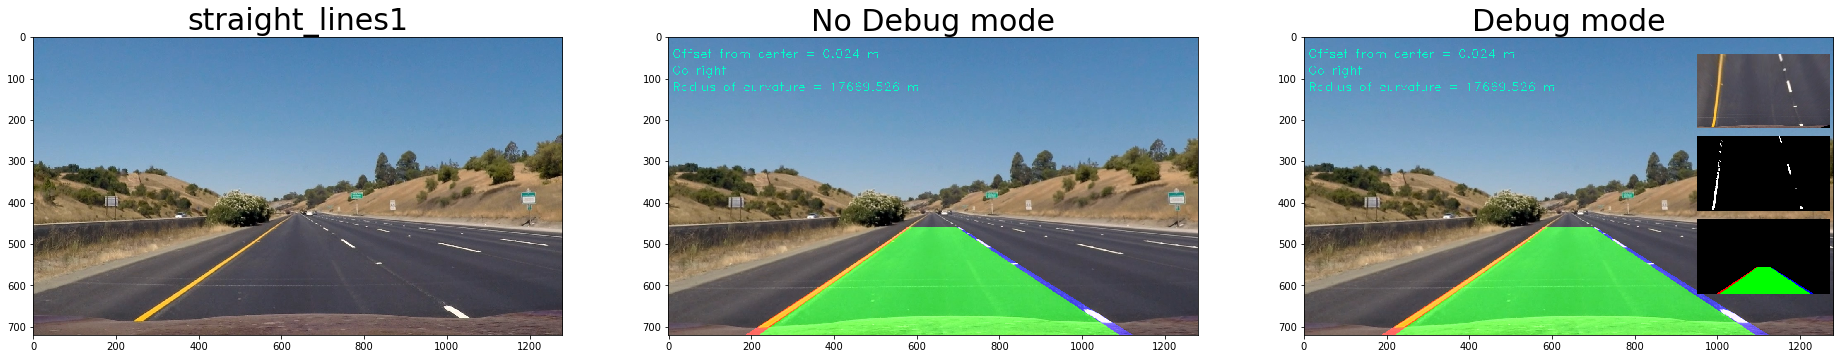

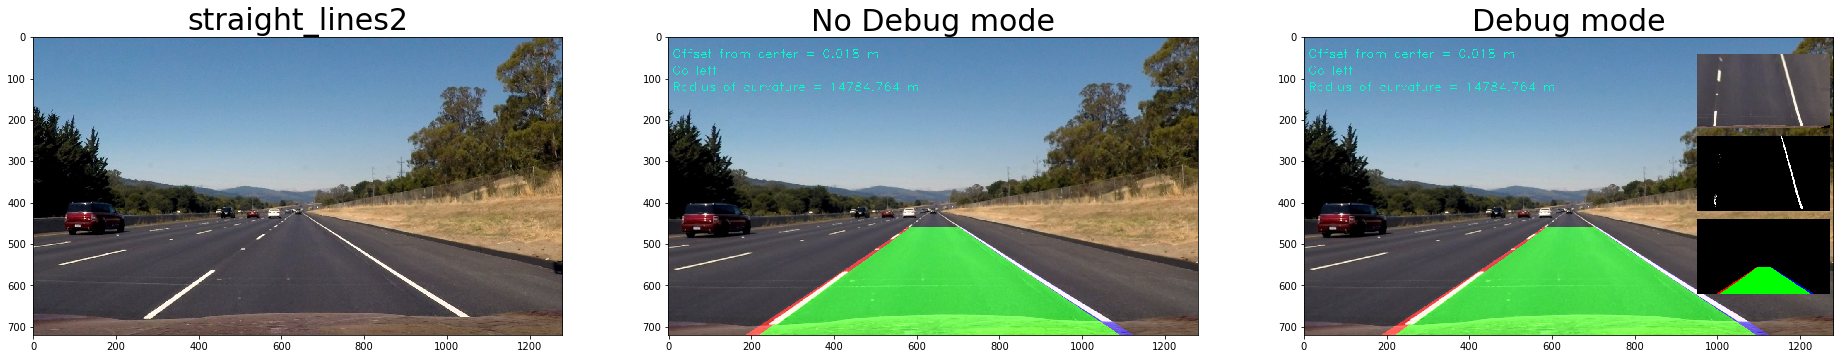

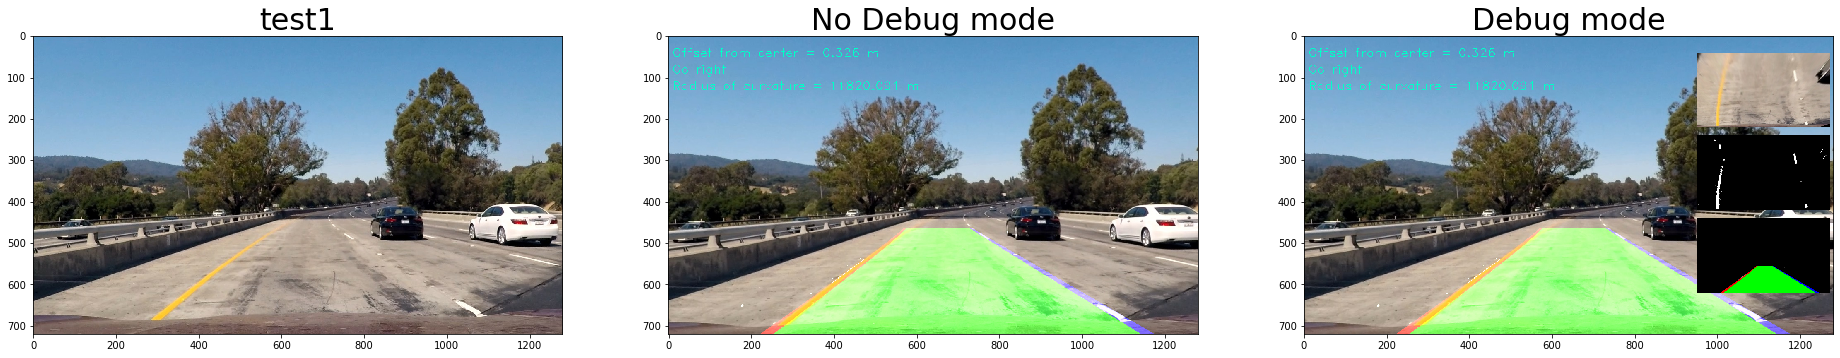

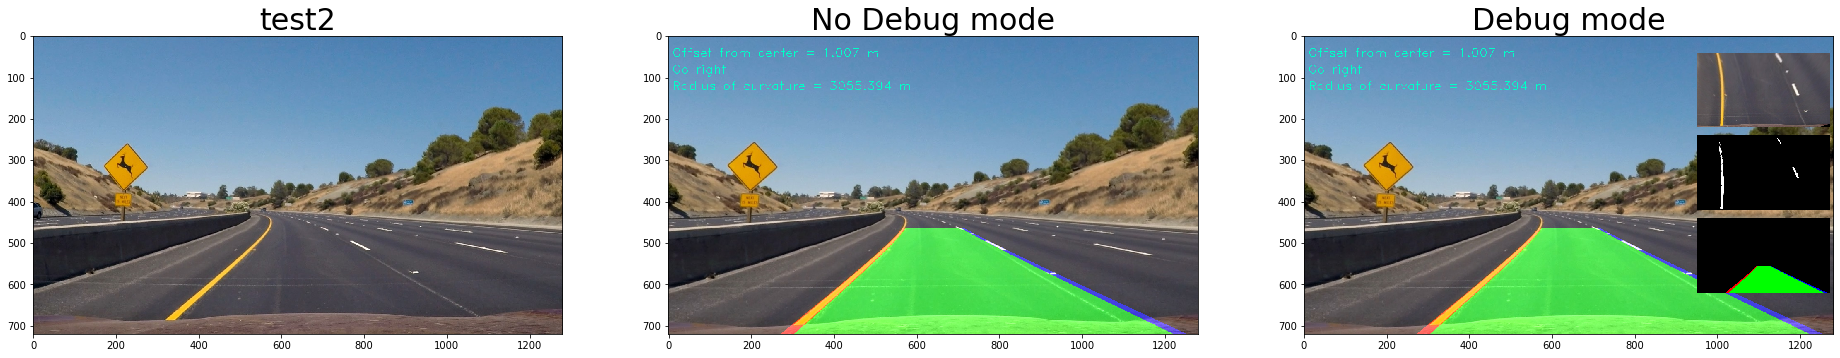

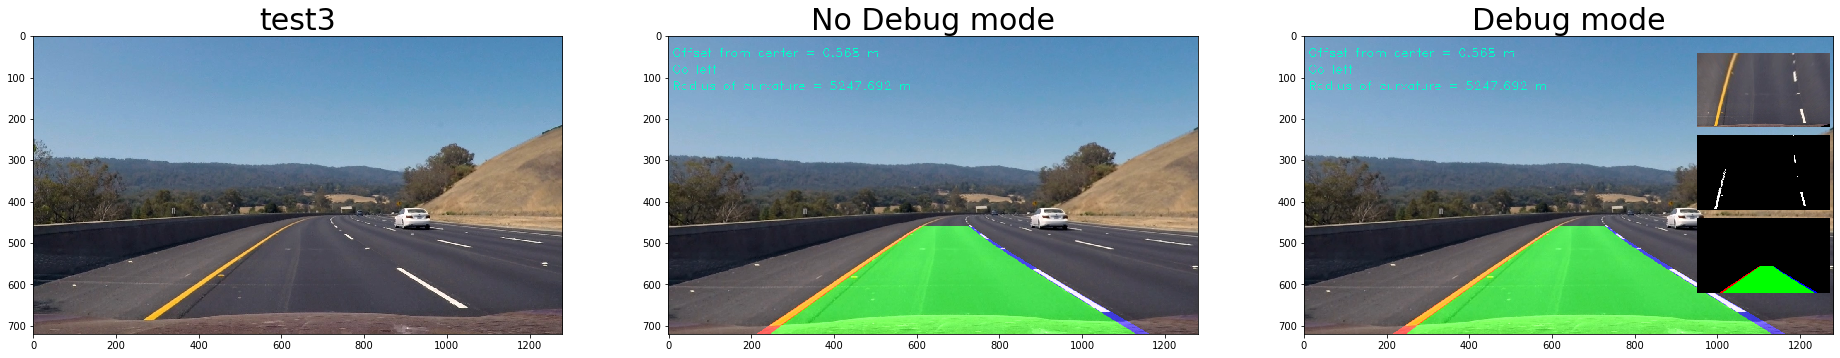

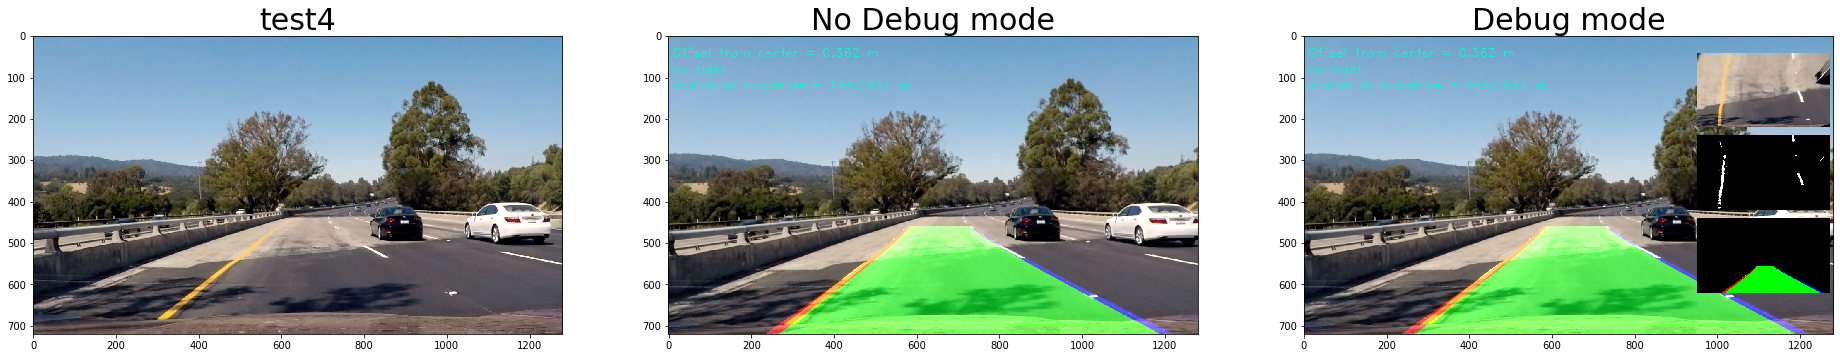

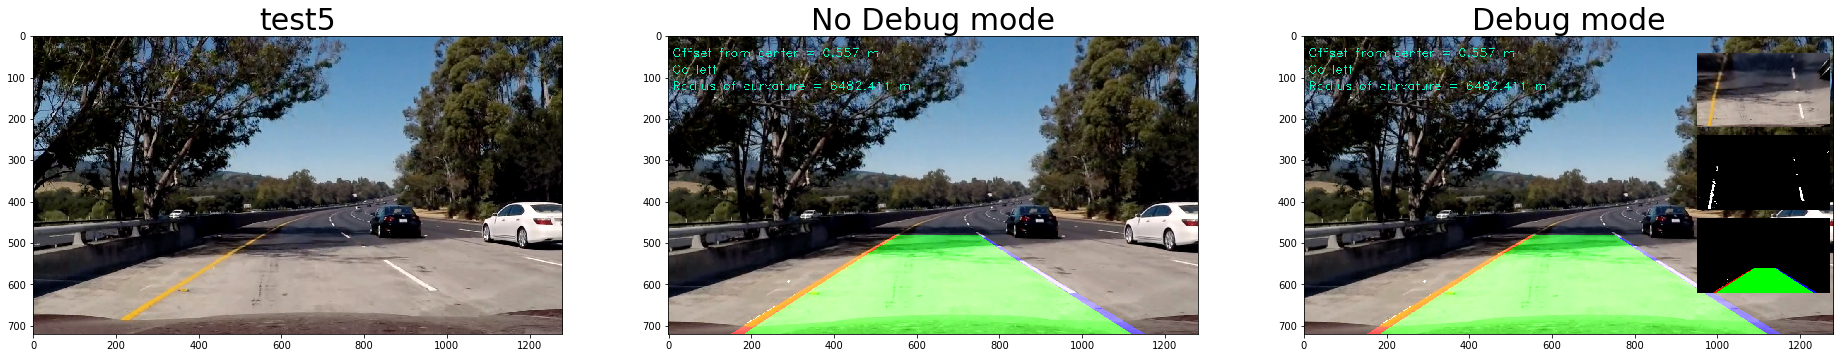

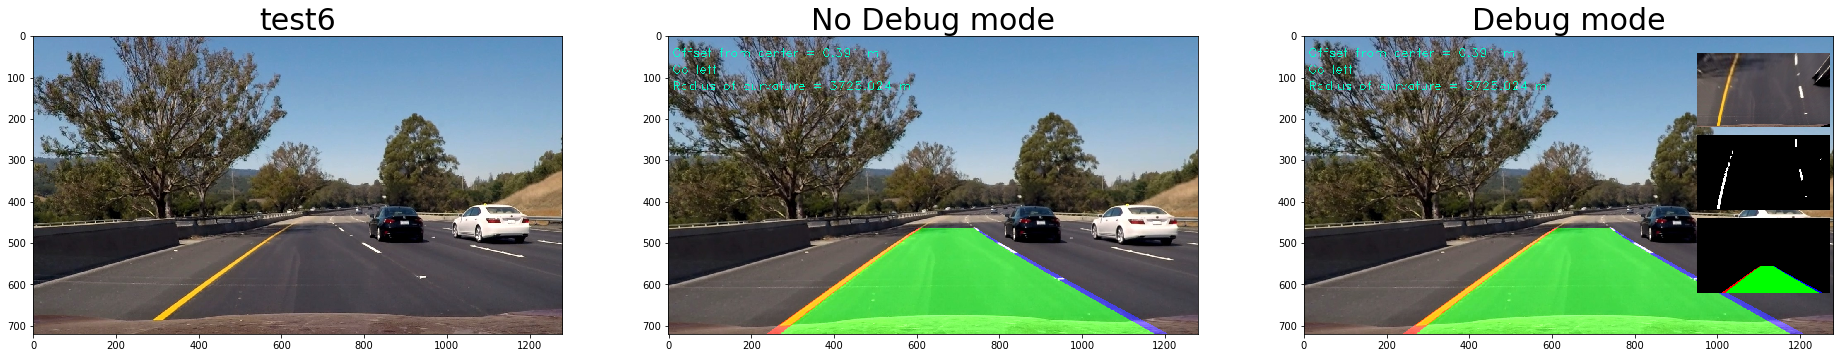

In [42]:
#Plotting original image, image with and without the Debug mode
images = glob.glob('test_images/*.jpg')

for img in images: #img is path
    print(img)
    start=img.find('\\')
    end=img.find('.')
    
    image1=cv2.imread(img) 
    image1=cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2=pipeline(image1,"0")
    image3=pipeline(image1,"1")
    plt_images(image1, img[start+1:end], image2, 'No Debug mode', image3 , 'Debug mode')
  
    
   
